## DEEP LEARNING KULLANARAK SES SİNYALLARİNİ SINIFLANDIRMA

dataset = https://urbansounddataset.weebly.com/urbansound8k.html

**Ses dosyalarının analiz edilmesi ve MFCC'lerinin çıkarılması.**

Adım 1 : Veri setini analiz için hazırlama ve ses sinyal özelliklerini çıkarma. (Mel-frequency Cepstral Coefficients(MFCC) kullanarak yapılacak.) 

Adım 2 : CNN ile model oluşturup modeli eğiteceğiz.

Adım 3 : Modeli kullanarak ses dosyasının sınıfını tahmin edeceğiz. 

kaynak video : https://www.youtube.com/watch?v=4_SH2nfbQZ8

### Adım 1 : Veri Setini Hazırlama ve MFCC ile Ses Sinyallerinden Öznitelik Çıkarma 

In [1]:
import tensorflow as tf
print(tf.__version__)

2.16.1


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import librosa
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

In [3]:
import librosa
audio_file_path = "UrbanSound8K/UrbanSound8K/audio/fold5/100263-2-0-143.wav"
librosa_audio_data, librosa_sample_rate = librosa.load(audio_file_path) # ses dosyasını örnek olarak ekledik

In [4]:
print(librosa_audio_data) # ses dosyasını dijital hale getirdik, 1d array
print(librosa_sample_rate) # ses dosyasının örnekleme frekansı

[0.00426048 0.00792833 0.00714055 ... 0.0058561  0.00561863 0.00630891]
22050


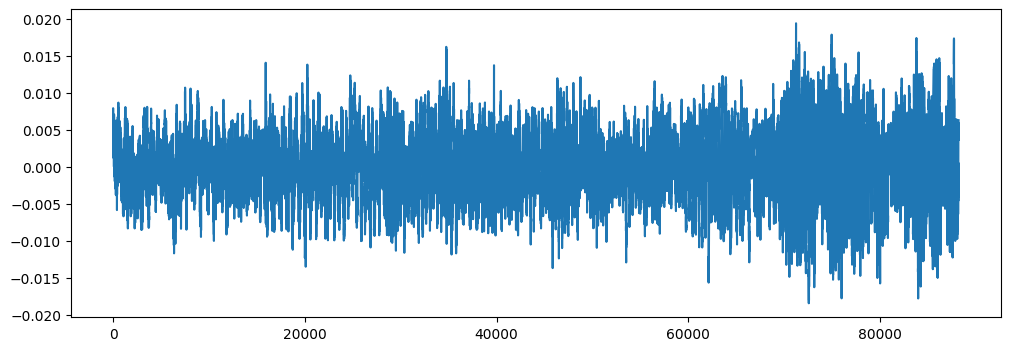

In [5]:
plt.figure(figsize=(12, 4)) # ses dosyasının dalga formunu, ses dosyasının zaman içindeki değişimini gözlemlemek için
plt.plot(librosa_audio_data)
plt.show()

In [6]:
from scipy.io import wavfile as wav
wave_sample_rate, wave_audio = wav.read(audio_file_path)

In [7]:
wave_audio # 2d array

array([[219, 143],
       [215, 220],
       [204, 288],
       ...,
       [337,  41],
       [320,  71],
       [311,  92]], dtype=int16)

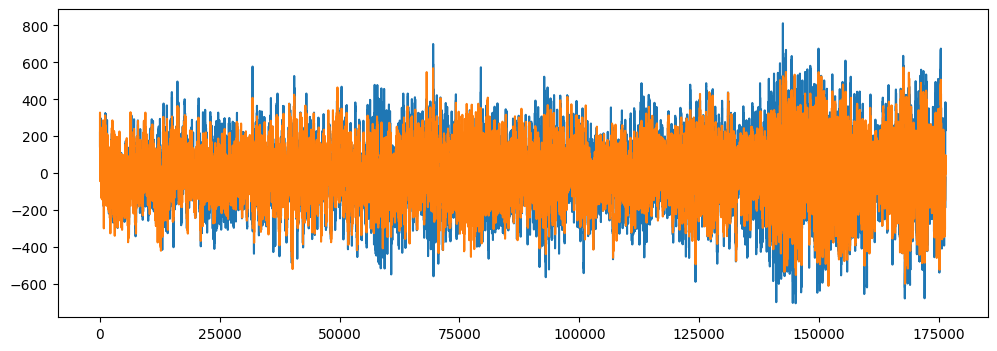

In [8]:
# 2 ses üst üste
plt.figure(figsize=(12, 4))
plt.plot(wave_audio)
plt.show()

## Özellik Çıkarımı 

In [9]:
mfccs = librosa.feature.mfcc(y=librosa_audio_data, sr=librosa_sample_rate, n_mfcc=40) # n_mfcc: çıkarılacak öznitellik sayısı
print(mfccs.shape)

(40, 173)


In [10]:
mfccs

array([[-4.7153787e+02, -4.4912976e+02, -4.4744662e+02, ...,
        -4.4174377e+02, -4.3948465e+02, -4.4826764e+02],
       [ 1.0039217e+02,  9.8589622e+01,  9.5115524e+01, ...,
         1.1791698e+02,  1.1520094e+02,  1.0672363e+02],
       [-2.1784367e+01, -2.0289974e+01, -2.0491684e+01, ...,
        -2.7890919e+01, -1.9016788e+01, -5.2057104e+00],
       ...,
       [-7.6563841e-01,  3.7504712e-01,  1.2162282e+00, ...,
         1.0650096e+00, -8.0678463e-02,  1.8818051e+00],
       [ 2.7869029e+00,  1.5277607e+00,  2.1518312e+00, ...,
        -1.1723335e+01, -1.1164774e+01, -6.5244627e+00],
       [ 3.9944458e+00, -3.0450649e+00, -6.5705328e+00, ...,
        -6.1732063e+00, -4.8374467e+00, -1.0105185e-02]], dtype=float32)

In [11]:
audio_dataset_path = "UrbanSound8K/UrbanSound8K/audio"
metadata = pd.read_csv("UrbanSound8K/UrbanSound8K/metadata/UrbanSound8K.csv")
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [12]:
def features_extractor(file):
    audio, sample_rate = librosa.load(file_name, res_type="kaiser_fast")
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    return mfccs_scaled_features

In [13]:
extracted_features = []

for index_num, row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path), "fold" + str(row["fold"]) + "/", str(row["slice_file_name"]))
    final_class_labels = row["class"]
    data = features_extractor(file_name)
    extracted_features.append([data, final_class_labels])

3554it [03:54, 14.48it/s]C:\Users\rabia\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
8326it [08:38, 21.57it/s]C:\Users\rabia\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
C:\Users\rabia\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(
8732it [09:05, 16.02it/s]


In [14]:
extracted_features_df = pd.DataFrame(extracted_features, columns=["features", "class"])
extracted_features_df.head()

,features,class
0,"[-217.35526, 70.22339, -130.38527, -53.282898,...",dog_bark
1,"[-424.09818, 109.34077, -52.919525, 60.86475, ...",children_playing
2,"[-458.79114, 121.38419, -46.520657, 52.00812, ...",children_playing
3,"[-413.89984, 101.66373, -35.42945, 53.036354, ...",children_playing
4,"[-446.60352, 113.68541, -52.402214, 60.30205, ...",children_playing


In [15]:
X = np.array(extracted_features_df["features"].tolist())
y = np.array(extracted_features_df["class"].tolist())

In [16]:
X.shape

(8732, 40)

In [17]:
y

array(['dog_bark', 'children_playing', 'children_playing', ...,
       'car_horn', 'car_horn', 'car_horn'], dtype='<U16')

In [18]:
# 10 farklı sınıf var ve bunları 0 ve 1'lerle temsil etmemiz gerekiyor o sebeple encoding 

# 1 0 0 0 0 0 0 0 0 0 = air_conditioner
# 0 1 0 0 0 0 0 0 0 0 = car_horn
# 0 0 1 0 0 0 0 0 0 0 = children_playing
# 0 0 0 1 0 0 0 0 0 0 = dog_bark
# 0 0 0 0 1 0 0 0 0 0 = drilling
# 0 0 0 0 0 1 0 0 0 0 = engine_idling
# 0 0 0 0 0 0 1 0 0 0 = gun_shot
# 0 0 0 0 0 0 0 1 0 0 = jackhammer
# 0 0 0 0 0 0 0 0 1 0 = siren
# 0 0 0 0 0 0 0 0 0 1 = street_music gibi


labelencoder = LabelEncoder()
y = to_categorical(labelencoder.fit_transform(y))

In [19]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [20]:
# Train test ayırıyoruz

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=0)

In [21]:
X_train

array([[-1.3110471e+02,  1.1250591e+02, -2.2574696e+01, ...,
         3.2466521e+00, -1.3690239e+00,  2.7557547e+00],
       [-1.3670342e+01,  9.1085083e+01, -7.7927337e+00, ...,
        -3.2530508e+00, -5.2774529e+00, -1.5569718e+00],
       [-4.9871544e+01,  2.6535282e-01, -2.0500937e+01, ...,
         2.8545945e+00, -1.6092046e+00,  3.5248058e+00],
       ...,
       [-4.2701236e+02,  9.2623047e+01,  3.1293974e+00, ...,
         7.4264127e-01,  7.3349088e-01,  7.1100885e-01],
       [-1.4575461e+02,  1.3626578e+02, -3.3515522e+01, ...,
         1.4681194e+00, -2.0091701e+00, -8.8218170e-01],
       [-4.2103134e+02,  2.1065454e+02,  3.4906614e+00, ...,
        -5.3888674e+00, -3.3713608e+00, -1.5665114e+00]], dtype=float32)

In [22]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [23]:
X_train.shape

(6985, 40)

In [24]:
X_test.shape

(1747, 40)

In [25]:
y_train.shape

(6985, 10)

In [26]:
y_test.shape

(1747, 10)

### Adım 2 : CNN Modelinin kurulması ve Modelin Eğitilmesi

In [27]:
num_labels = 10

In [28]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D

model = Sequential()

model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(40,1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_labels, activation='softmax'))

C:\Users\rabia\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [29]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 38, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 19, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 17, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 8, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 6, 256)              │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 191,882 (749.54 KB)

 Trainable params: 191,882 (749.54 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

In [31]:
epochscount = 300
num_batch_size = 32

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=epochscount, validation_data=(X_test, y_test), verbose=1)

Epoch 1/300
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.3164 - loss: 1.8779 - val_accuracy: 0.5129 - val_loss: 1.3839
Epoch 2/300
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5431 - loss: 1.3126 - val_accuracy: 0.6148 - val_loss: 1.1547
Epoch 3/300
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6294 - loss: 1.0837 - val_accuracy: 0.6651 - val_loss: 0.9611
Epoch 4/300
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7101 - loss: 0.8723 - val_accuracy: 0.7384 - val_loss: 0.7879
Epoch 5/300
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7482 - loss: 0.7478 - val_accuracy: 0.7682 - val_loss: 0.7593
Epoch 6/300
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7895 - loss: 0.6210 - val_accuracy: 0.8134 - val_loss: 0.5874
Epoch 7/300
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8302 - loss: 0.4998 - val_accuracy: 0.8288 - val_loss: 0.5250
Epoch 8/300
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8514 - loss: 0.4351 - val_acc

In [32]:
validation_test_set_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(validation_test_set_accuracy[1])

0.9095592498779297


In [33]:
X_test[1]

array([-466.17957   ,    1.0950246 ,  -34.01389   ,   35.339348  ,
        -14.881481  ,  -19.12843   ,   -0.5816844 ,  -16.130579  ,
        -21.339073  ,    7.6736345 ,  -29.16449   ,  -18.950253  ,
         -2.9579992 ,   -8.162331  ,  -15.153101  ,   -6.6048055 ,
         -7.5685973 ,    9.340646  ,   14.4331    ,   21.934181  ,
         20.861397  ,    1.3340123 ,  -19.228804  ,   -4.6302304 ,
         -1.0564744 ,    3.215267  ,   -6.984281  ,  -16.414577  ,
        -10.0286455 ,   13.009954  ,    0.53346074,  -23.843393  ,
        -15.267321  ,    9.245734  ,   10.367627  ,   -0.5832011 ,
         -1.2624053 ,   17.700018  ,   13.847463  ,   -5.1862826 ],
      dtype=float32)

In [34]:
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
predicted_classes

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


array([5, 9, 4, ..., 1, 2, 3], dtype=int64)

### Adım 3 : Modeli Kullanarak Ses Dosyasının Tahmin Edilmesi

In [35]:
filename = "UrbanSound8K/UrbanSound8K/audio/fold1/24074-1-0-8.wav"
sound_signal, sample_rate = librosa.load(filename, res_type="kaiser_fast")
mfccs_features = librosa.feature.mfcc(y=sound_signal, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)

In [36]:
print(mfccs_scaled_features)

[-154.26836     133.95139     -50.936527     17.583927     -0.8391421
   12.33201      -0.51373315   21.468214    -15.112723     13.492365
   -7.2374096    -0.19424897   -9.773221      8.516404      1.9693683
   15.030424      0.86438334   10.118007     -1.9612463     4.0995636
  -11.328976    -13.329483    -10.723755      5.618018      4.5967984
   -5.563774     -7.873722     12.25553      17.520714      0.6628409
  -23.936869    -16.480968     12.836585     15.374969      4.774599
    4.135561     -1.6536081   -21.323961    -19.487118     11.440806  ]


In [37]:
mfccs_scaled_features = mfccs_scaled_features.reshape(1, -1)

In [38]:
print(mfccs_scaled_features.shape)

(1, 40)


In [39]:
print(mfccs_scaled_features)

[[-154.26836     133.95139     -50.936527     17.583927     -0.8391421
    12.33201      -0.51373315   21.468214    -15.112723     13.492365
    -7.2374096    -0.19424897   -9.773221      8.516404      1.9693683
    15.030424      0.86438334   10.118007     -1.9612463     4.0995636
   -11.328976    -13.329483    -10.723755      5.618018      4.5967984
    -5.563774     -7.873722     12.25553      17.520714      0.6628409
   -23.936869    -16.480968     12.836585     15.374969      4.774599
     4.135561     -1.6536081   -21.323961    -19.487118     11.440806  ]]


In [40]:
result_array = model.predict(mfccs_scaled_features)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [41]:
result_array

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [42]:
result_classes = ["air_conditioner", "car_horn", "children_playing", "dog_bark", "drilling", "engine_idling", "gun_shot", "jackhammer", "siren", "street_music"]

result = np.argmax(result_array[0])
print(result_classes[result])

car_horn


In [43]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test.argmax(axis=1), predicted_classes)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[192   0   0   1   1   0   0   0   0   1]
 [  1  78   0   2   2   1   0   1   1   5]
 [  1   1 173   9   2   3   3   0   1  12]
 [  2   1   5 160   1   3   2   0   3   5]
 [  1   0   1   0 185   1   0   8   0   6]
 [  0   1   3   0   0 210   0   0   0   2]
 [  0   0   4   2   0   0  77   0   1   3]
 [  0   0   0   0   8   0   0 177   0   2]
 [  1   0   4   2   1   0   0   1 187   3]
 [  0   5  10   3   5   2   2   4   2 150]]


In [44]:
from sklearn.metrics import classification_report
cr = classification_report(y_test.argmax(axis=1), predicted_classes)
print("Classification Report:")
print(cr)

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       195
           1       0.91      0.86      0.88        91
           2       0.86      0.84      0.85       205
           3       0.89      0.88      0.89       182
           4       0.90      0.92      0.91       202
           5       0.95      0.97      0.96       216
           6       0.92      0.89      0.90        87
           7       0.93      0.95      0.94       187
           8       0.96      0.94      0.95       199
           9       0.79      0.82      0.81       183

    accuracy                           0.91      1747
   macro avg       0.91      0.90      0.91      1747
weighted avg       0.91      0.91      0.91      1747



In [45]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test.argmax(axis=1), predicted_classes)
print("Accuracy:", accuracy)

Accuracy: 0.909559244419004


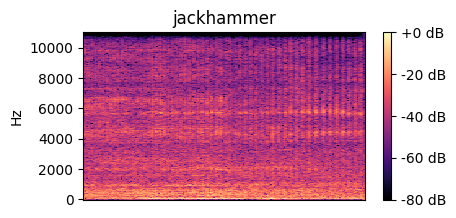

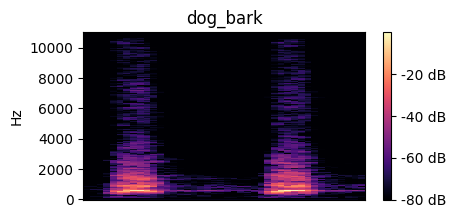

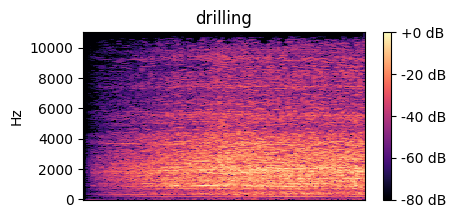

In [46]:
arr = np.array(metadata["slice_file_name"])
fold = np.array(metadata["fold"])
cla = np.array(metadata["class"])

# Belirli katmandaki ses dosyalarını yükleme ve spektrogramlarını görüntüleme
for i in range(192, 197, 2):
    path = 'UrbanSound8K/UrbanSound8K/audio/fold' + str(fold[i]) + '/' + arr[i]
    data, sampling_rate = librosa.load(path)
    plt.figure(figsize=(10, 10))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
    plt.subplot(4, 2, 1)
    librosa.display.specshow(D, y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title(cla[i])
    plt.show()

Epoch 1/300
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9654 - loss: 0.4640 - val_accuracy: 0.9714 - val_loss: 0.2463
Epoch 2/300
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9712 - loss: 0.1413 - val_accuracy: 0.9771 - val_loss: 0.2042
Epoch 3/300
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9856 - loss: 0.0523 - val_accuracy: 0.9771 - val_loss: 0.2727
Epoch 4/300
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9873 - loss: 0.0442 - val_accuracy: 0.9771 - val_loss: 0.2815
Epoch 5/300
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9903 - loss: 0.0385 - val_accuracy: 0.9748 - val_loss: 0.2646
Epoch 6/300
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9877 - loss: 0.0296 - val_accuracy: 0.9794 - val_loss: 0.2721
Epoch 7/300
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9892 - loss: 0.0267 - val_accuracy: 0.9714 - val_loss: 0.3696
Epoch 8/300
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9930 - loss: 0.0247 - val_acc

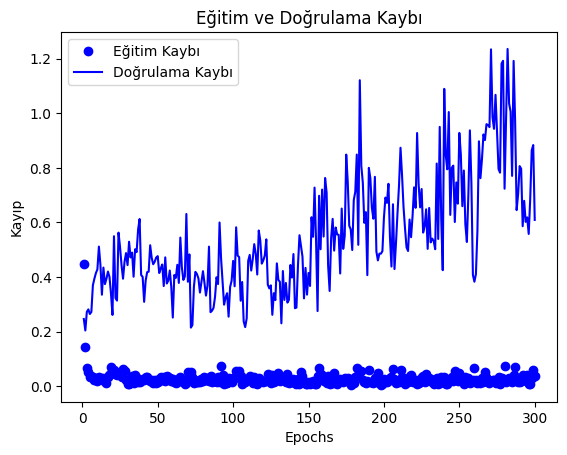

In [61]:
history = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=epochscount, validation_data=(X_test, y_test), verbose=1)

# Eğitim ve doğrulama kayıpları
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Grafik
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'bo', label='Eğitim Kaybı')
plt.plot(epochs, val_loss, 'b', label='Doğrulama Kaybı')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epochs')
plt.ylabel('Kayıp')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


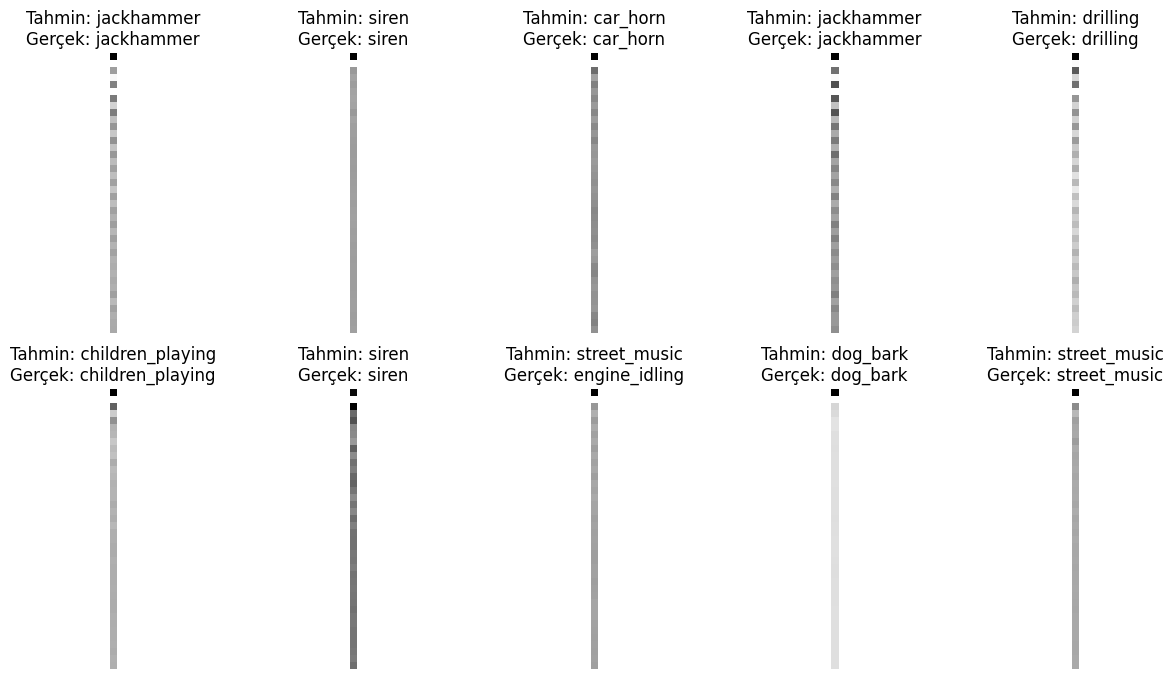

In [58]:
num_examples = 10

random_indices = np.random.choice(range(len(X_test)), size=num_examples, replace=False)
test_samples = X_test[random_indices]
true_labels = np.argmax(y_test[random_indices], axis=1)

predictions = model.predict(test_samples)
predicted_labels = np.argmax(predictions, axis=1)

plt.figure(figsize=(15, 8))
for i in range(num_examples):
    plt.subplot(2, num_examples // 2, i + 1)
    plt.imshow(test_samples[i].reshape(40, -1), cmap='gray')
    plt.title(f'Tahmin: {result_classes[predicted_labels[i]]}\nGerçek: {result_classes[true_labels[i]]}')
    plt.axis('off')
plt.show()

In [60]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Modelin test seti üzerinde performansını değerlendirme
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

# Modelin doğrulama seti üzerindeki performansı
validation_loss, validation_accuracy = model.evaluate(X_val, y_val, verbose=0)

print("Doğrulama Seti Performansı:")
print(f"- Loss: {validation_loss}")
print(f"- Accuracy: {validation_accuracy}")

print("Test Seti Performansı:")
print(f"- Loss: {test_loss}")
print(f"- Accuracy: {test_accuracy}")

# Performans karşılaştırması
if test_accuracy < validation_accuracy:
    print("Model, test seti üzerinde beklenenden daha kötü performans gösteriyor. Aşırı uyum olabilir.")
else:
    print("Model, test seti üzerinde iyi performans gösteriyor.")

Doğrulama Seti Performansı:
- Loss: 0.5363432765007019
- Accuracy: 0.9793814420700073
Test Seti Performansı:
- Loss: 0.37844252586364746
- Accuracy: 0.9851258397102356
Model, test seti üzerinde iyi performans gösteriyor.
